# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Импортируем все необдходимое

In [73]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from tqdm import tqdm
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler


RANDOM_SEED = 42

##  Откроем и изучим файл

In [74]:
frame = pd.read_csv('datasets/users_behavior.csv')

In [75]:
frame.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


### Проверим типы данных

In [76]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


#### Результаты проверки 
Изменим тип поля messages на int, потому что дробных сообщений быть не может

In [77]:
frame['messages']=frame['messages'].astype("int")

### Проверим  дубликаты

In [78]:
frame.duplicated().sum()

0

#### Результаты проверки 
Дубликатов не найдено

### Проверка на корректность наименований столбцов

In [79]:
frame.columns

Index(['calls', 'minutes', 'messages', 'mb_used', 'is_ultra'], dtype='object')

#### Результаты проверки 
Имена столбцов заданы корректно

### Проверим значения содержащиеся в столбцах

In [80]:
frame.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


### Вывод

1. Пропущенных значений нет
1. Типы столбцов в порядке
1. Дубликатов нет
2. Датафрейм не сбалансирован. Надо произвести балансировку с помощью imbalanced-learn

# Разобьем данные на выборки

Разделим данные на целевой столбец и матрицу признаков

In [182]:
X = frame.loc[:,~frame.columns.isin(["is_ultra"])]
y = frame["is_ultra"]

Так как у нас нет скрытой тестовой выборки - сделаем свою

In [183]:
(X_train,
 X_test,
 y_train,
 y_test) = train_test_split(X,
                            y,
                            test_size = 0.33,
                            random_state = RANDOM_SEED
                                       )


Создадим функцию для описанию выборки

In [184]:
def describe(X: pd.DataFrame, y: pd. Series):
    X_copy = X.copy()
    X_copy["is_ultra"] = y
    return X_copy.describe()

Проведем балансировку

In [185]:
X_balanced = X_train
y_balanced = y_train

In [115]:
over = RandomOverSampler(sampling_strategy=1)
X_balanced, y_balanced = over.fit_resample(X_train, y_train)
# under = RandomUnderSampler(sampling_strategy=0.7)
# X, y = under.fit_resample(X, y)

Проведем иследование сформированной выборки

In [186]:
describe(X_balanced, y_balanced)

,calls,minutes,messages,mb_used,is_ultra
count,2153.000000,2153.000000,2153.000000,2153.000000,2153.000000
mean,63.569438,441.917255,38.439387,17088.302411,0.302369
std,33.207525,234.717055,36.468135,7426.242514,0.459391
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,41.000000,279.060000,9.000000,12388.400000,0.000000
50%,63.000000,432.750000,30.000000,16835.990000,0.000000
75%,83.000000,578.570000,57.000000,21289.280000,1.000000
max,203.000000,1566.450000,224.000000,49745.730000,1.000000


Сравним с обучающей выборкой

In [187]:
describe(X_train, y_train)

,calls,minutes,messages,mb_used,is_ultra
count,2153.000000,2153.000000,2153.000000,2153.000000,2153.000000
mean,63.569438,441.917255,38.439387,17088.302411,0.302369
std,33.207525,234.717055,36.468135,7426.242514,0.459391
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,41.000000,279.060000,9.000000,12388.400000,0.000000
50%,63.000000,432.750000,30.000000,16835.990000,0.000000
75%,83.000000,578.570000,57.000000,21289.280000,1.000000
max,203.000000,1566.450000,224.000000,49745.730000,1.000000


Теперь разделим тестовую выборку на тестовую и валидационную

In [188]:
(X_valid,
 X_test,
 y_valid,
 y_test) = train_test_split(X_test,
                            y_test,
                            test_size = 0.5,
                            random_state = RANDOM_SEED
                                       )

#  Исследуем модели

## Random Forest

In [189]:
best_RF = None
best_accuracy_RF = 0
best_est_RF = 0
best_depth_RF = 0
exit = False
est = 5
parameters = []
for est in tqdm(range(2,10)):
    for depth in range(2, 10):
        RF = RandomForestClassifier(random_state = RANDOM_SEED,n_estimators = est, max_depth = depth)
        RF.fit(X_balanced, y_balanced)
        prediction_valid_RF = RF.predict(X_valid)
        accuracy_RF = accuracy_score(prediction_valid_RF, y_valid)
        parameters.append((est, depth, accuracy_RF))
        if best_accuracy_RF < accuracy_RF:
            best_RF = RF
            best_depth_RF = depth
            best_est_RF = est
            best_accuracy_RF = accuracy_RF
            

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.20it/s]


In [190]:
best_est_RF, best_depth_RF, best_accuracy_RF

(7, 8, 0.7962264150943397)

Для ускорения повторного обращения к блокноту создадим лес по лучшим параметрам для сбалансированной обучающей выборки (33, 4)
Для несбалансированной выборки лучшая точность достигается при 4, 4


In [165]:
best_RF = RandomForestClassifier(random_state = RANDOM_SEED,n_estimators = 33, max_depth = 4)
best_RF.fit(X_balanced, y_balanced)

RandomForestClassifier(max_depth=4, n_estimators=33, random_state=42)

## Decision Tree

In [191]:
best_DT = None
best_accuracy_DT = 0
best_depth_DT = 0
for depth in tqdm(range(2,20)):
    DT = DecisionTreeClassifier(random_state = RANDOM_SEED, max_depth = depth)
    DT.fit(X_balanced, y_balanced)
    prediction_valid_DT = DT.predict(X_valid)
    accuracy_DT = accuracy_score(prediction_valid_DT, y_valid)
    if best_accuracy_DT < accuracy_DT:
        best_DT = DT
        best_accuracy_DT = accuracy_DT
        best_depth_DT = depth

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 29.53it/s]


Лучшая модель Decision tree


In [192]:
describe(X_balanced, y_balanced)

,calls,minutes,messages,mb_used,is_ultra
count,2153.000000,2153.000000,2153.000000,2153.000000,2153.000000
mean,63.569438,441.917255,38.439387,17088.302411,0.302369
std,33.207525,234.717055,36.468135,7426.242514,0.459391
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,41.000000,279.060000,9.000000,12388.400000,0.000000
50%,63.000000,432.750000,30.000000,16835.990000,0.000000
75%,83.000000,578.570000,57.000000,21289.280000,1.000000
max,203.000000,1566.450000,224.000000,49745.730000,1.000000


In [193]:
accuracy = best_accuracy_DT*100
print(f"{best_depth_DT=}\nbest_accuracy_DT={accuracy:.02f}\n")

best_depth_DT=12
best_accuracy_DT=78.49



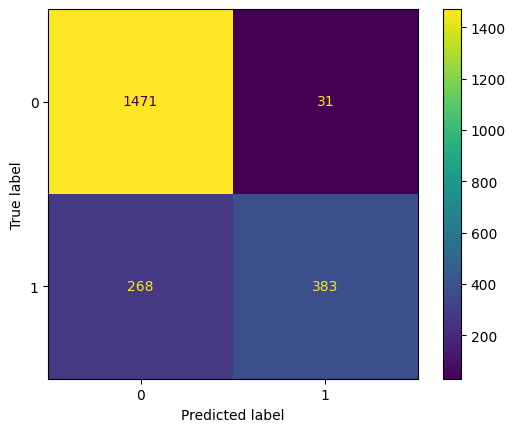

In [194]:

disp = ConfusionMatrixDisplay.from_estimator(best_RF, X_train, y_train)

## LogisticRegression

In [195]:
LR = LogisticRegression(random_state = RANDOM_SEED,max_iter= 1000,tol=1e-5,solver = 'lbfgs' )
LR.fit(X_train, y_train)
prediction_valid_LR = LR.predict(X_valid)
accuracy_LR = accuracy_score(prediction_valid_LR, y_valid)

In [196]:
print(f"Logistic Regression: {accuracy_LR}")
print(f"Random Forest: {best_accuracy_RF}")
print(f"Decision Tree: {best_accuracy_DT}")

Logistic Regression: 0.7226415094339622
Random Forest: 0.7962264150943397
Decision Tree: 0.7849056603773585


## Вывод 

Основываясь на показателе точности, можно  прийти к выводу, что наиболее качественные результаты прогнозирует Random Forest

# Проверьте модель на тестовой выборке

In [197]:
prediction_test_LR = LR.predict(X_test)
prediction_test_RF = best_RF.predict(X_test)
prediction_test_DT = best_DT.predict(X_test)

In [198]:
accuracy_LR_test = accuracy_score(prediction_test_LR, y_test)
accuracy_RF_test = accuracy_score(prediction_test_RF, y_test)
accuracy_DT_test = accuracy_score(prediction_test_DT, y_test)

In [199]:
print(f"Logistic Regression: {accuracy_LR_test}")
print(f"Random Forest: {accuracy_RF_test}")
print(f"Decision Tree: {accuracy_DT_test}")

Logistic Regression: 0.7608286252354048
Random Forest: 0.8041431261770244
Decision Tree: 0.7796610169491526


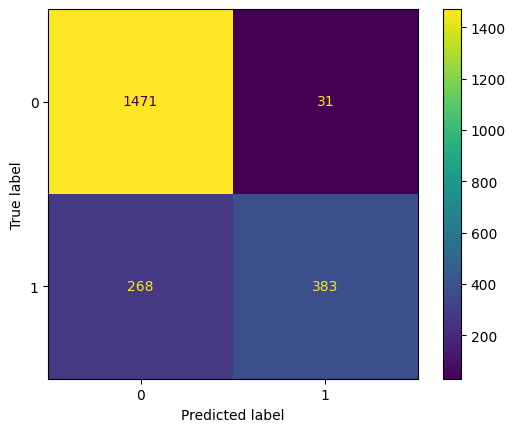

In [200]:
disp = ConfusionMatrixDisplay.from_estimator(best_RF, X_train, y_train)

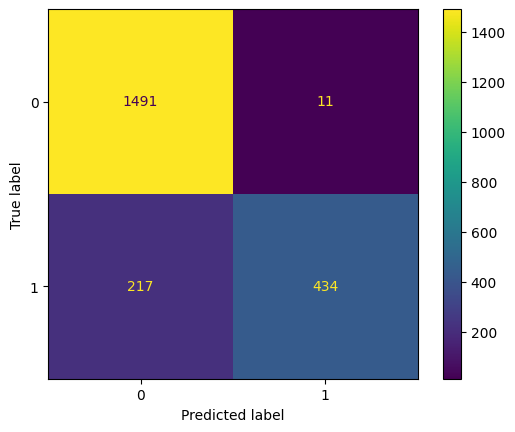

In [201]:
disp = ConfusionMatrixDisplay.from_estimator(best_DT, X_train, y_train)

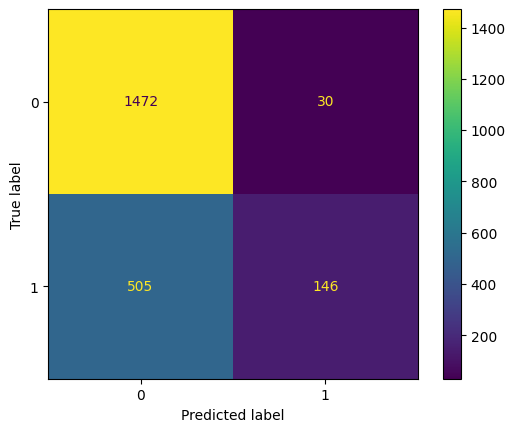

In [202]:
disp = ConfusionMatrixDisplay.from_estimator(LR, X_train, y_train)

## Вывод

Средняя точность RandomForest оказалась выше прочих моделей, но качество ответов лучше в DesicionTree. 
логистическая регрессия делает сосай.